In [308]:
!pip install arch yfinance > log.txt

In [355]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [356]:
def get_hourly_data(name='BTC', start='2024-01-01', end='2024-10-01'):
    data = yf.download(f'{name}-USD', start=start, end=end, interval='1h')
    data['Returns'] = 100 * data['Adj Close'].pct_change().dropna()
    data['Log Returns'] = (np.log(data['Adj Close'])).diff()
    return data

def generate_HAR_data(data, w_len=7, m_len=30):
    """
    Функция для генерации нужных лагов для HAR модели из данных data.
    """
    new_data = data.copy()
    volatility = new_data['Log Returns'].resample('D').std()
    daily_returns = new_data['Log Returns'].resample('D').mean()

    rv_data = pd.DataFrame({
        'Datetime': pd.to_datetime(volatility.index),
        'rv': volatility.values,
        'daily returns': daily_returns.values
    })

    rv_data['rv w'] = rv_data['rv'].rolling(window=w_len).mean()
    rv_data['rv m'] = rv_data['rv'].rolling(window=m_len).mean()

    return rv_data

def generate_HARQ_data(data, w_len=7, m_len=30):
    """
    Функция для генерации нужных лагов для HARQ модели из данных data.
    """
    new_data = data.copy()
    volatility = new_data['Log Returns'].resample('D').std()
    rq = new_data['Log Returns'].resample('D').apply(lambda x: np.sum(x**4)) # hours / 3
    daily_returns = new_data['Log Returns'].resample('D').mean()

    rv_data = pd.DataFrame({
        'Datetime': pd.to_datetime(rq.index),
        'rv': volatility.values,
        'rq': rq.values,
        'daily returns': daily_returns.values
    })

    rv_data['rv w'] = rv_data['rv'].rolling(window=w_len).mean()
    rv_data['rv m'] = rv_data['rv'].rolling(window=m_len).mean()

    rv_data['rq w'] = rv_data['rq'].rolling(window=w_len).mean()
    rv_data['rq m'] = rv_data['rq'].rolling(window=m_len).mean()

    return rv_data

def generate_HARJ_data(data, w_len=7, m_len=30):
    """
    Функция для генерации нужных лагов для HARJ (с д jump) модели из данных data.
    """
    new_data = data.copy()
    volatility = new_data['Log Returns'].resample('D').std()
    daily_returns = new_data['Log Returns'].resample('D').mean()
    bpv = new_data['Log Returns'].resample('D').apply(lambda x: np.sum(np.abs(x[1:]) * np.abs(x[:-1])))
    jump = np.maximum(volatility.values - bpv.values, 0)

    rv_data = pd.DataFrame({
        'Datetime': pd.to_datetime(volatility.index),
        'rv': volatility.values,
        'daily returns': daily_returns.values,
        'bpv': bpv,
        'jump': jump
    })

    rv_data['rv w'] = rv_data['rv'].rolling(window=w_len).mean()
    rv_data['rv m'] = rv_data['rv'].rolling(window=m_len).mean()

    return rv_data

In [399]:
class HAR:
  def __init__(self, name='HAR'):
    self.name = name

  def __fit_har(self, data):
    X = pd.DataFrame({
      'RV': data['rv'][:-1],
      'RV_w': data['rv w'][:-1],
      'RV_m': data['rv m'][:-1]
    })
    self.X = X

  def __fit_harq(self, data):
    X = pd.DataFrame({
      'RV': data['rv'][:-1],
      'RV_w': data['rv w'][:-1],
      'RV_m': data['rv w'][:-1],
      'RQ': np.sqrt(data['rq'][:-1]) * data['rv'][:-1],
      'RQ_w': np.sqrt(data['rq w'][:-1]) * data['rv w'][:-1],
      'RQ_m': np.sqrt(data['rq m'][:-1]) * data['rv m'][:-1],
    })
    self.X = X

  def __fit_harj(self, data):
    X = pd.DataFrame({
      'RV': data['rv'][:-1],
      'RV_w': data['rv w'][:-1],
      'RV_m': data['rv w'][:-1],
      'J': data['jump'][:-1]
    })
    self.X = X

  def fit(self, data):
    if self.name == 'HAR':
        self.__fit_har(data)
    elif self.name == 'HARQ':
        self.__fit_harq(data)
    elif self.name == 'HAR-J':
        self.__fit_harj(data)

    X = self.X.reset_index(drop=True)
    X = sm.add_constant(X)
    y = data['rv'][1:]
    y = y.reset_index(drop=True)
    model = sm.OLS(y, X).fit()
    self.model = model

  def predict(self, data):

    last_row = 0
    if self.name == 'HAR':
      last_row = data[['rv', 'rv w', 'rv m']].iloc[-1]
    elif self.name == 'HARQ':
      last_row = data[['rv', 'rv w', 'rv m', 'rq', 'rq w', 'rq m']].iloc[-1]
    elif self.name == 'HAR-J':
      last_row = data[['rv', 'rv w', 'rv m', 'jump']].iloc[-1]

    last_row_with_const = [1] + last_row.tolist()
    last_row_with_const = np.array(last_row_with_const).reshape(1, -1)
    predictions = self.model.predict(last_row_with_const)

    return predictions

def get_rolling_har_predictions(data, model_name='HAR', window_size=100):
    vol_forecast = []

    for i in range(window_size, len(data)):
        window_data = data[i - window_size : i]
        model = HAR(name=model_name)
        model.fit(window_data)
        vol_forecast.append(model.predict(window_data))

    return np.array(vol_forecast).flatten()

def get_naive_predictions(data, window=100):
    return np.array(data['rv'][window:]).flatten()

In [400]:
hourly_data = get_hourly_data()
har_data = generate_HAR_data(hourly_data)
har_data = har_data.dropna()
har_data.head(5)

[*********************100%***********************]  1 of 1 completed


,Datetime,rv,daily returns,rv w,rv m
29,2024-01-30 00:00:00+00:00,0.003377,-0.000324,0.003991,0.005173
30,2024-01-31 00:00:00+00:00,0.005175,-0.000342,0.004048,0.005200
31,2024-02-01 00:00:00+00:00,0.004437,0.000468,0.004189,0.005131
32,2024-02-02 00:00:00+00:00,0.004081,0.000103,0.003956,0.004937
33,2024-02-03 00:00:00+00:00,0.001429,-0.000185,0.003862,0.004840


In [401]:
har_predictions = get_rolling_har_predictions(har_data, model_name='HAR')
naive_predictions = get_naive_predictions(har_data)

In [402]:
def cut_data(data, predictions):
  """
  Функция обрезает данных из даты и predictions по одинаквым периодам, что бы можно было построить график или посчитать метрики
  """
  cut_predictions = predictions[:-1]
  predictions_size = len(cut_predictions)
  cut_realize_volatility = data['rv'][-predictions_size:]
  cut_datetime_axes = data['Datetime'][-predictions_size:]
  return cut_predictions, cut_realize_volatility, cut_datetime_axes

def plot_predictions(data, predictions):
  cut_predictions, cut_realize_volatility, cut_datetime_axes = cut_data(data, predictions)

  plt.figure(figsize=(12, 6))

  plt.plot(cut_datetime_axes, cut_realize_volatility, label='Realized Volatility', color='blue')
  plt.plot(cut_datetime_axes, cut_predictions, label='Predicted Volatility', color='red')
  plt.title('Predicted vs. Realized Volatility')
  plt.xlabel('Date')
  plt.ylabel('Volatility (%)')
  plt.legend()
  plt.grid()
  plt.show()

def calculate_metrics(data, predictions):
  cut_predictions, cut_realize_volatility, _ = cut_data(data, predictions)
  return {
      'MSE': ((cut_realize_volatility - cut_predictions).dropna()**2).mean(),
      'MAE': np.abs(cut_realize_volatility - cut_predictions).dropna().mean()
  }

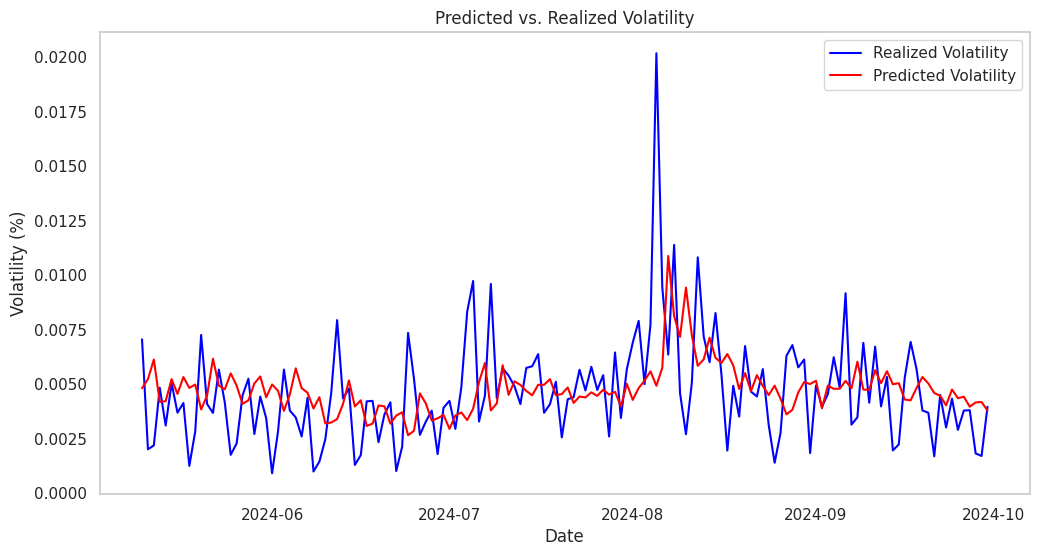

In [403]:
plot_predictions(har_data, har_predictions)

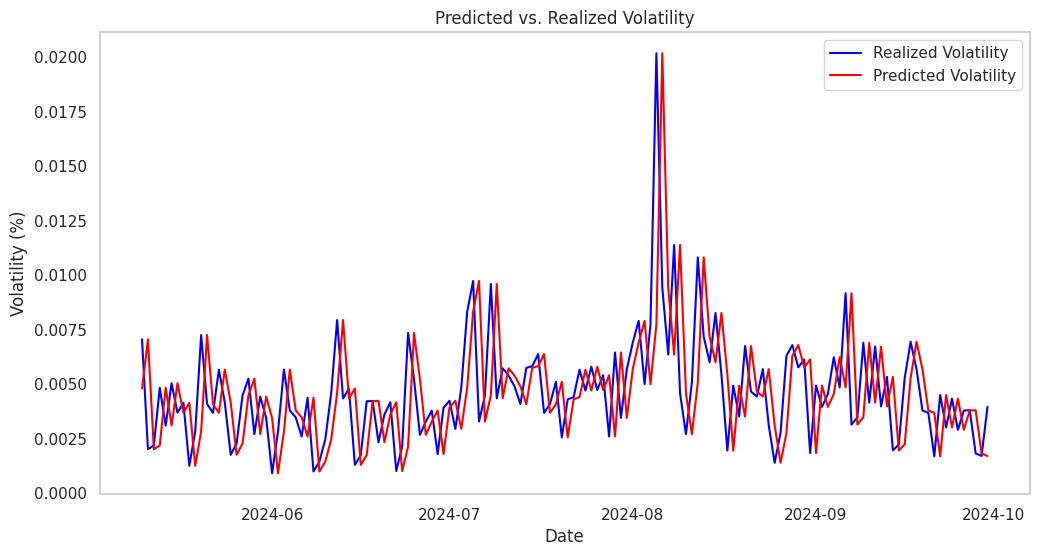

In [404]:
plot_predictions(har_data, naive_predictions)

In [405]:
print(calculate_metrics(har_data, har_predictions))
print(calculate_metrics(har_data, naive_predictions))

{'MSE': 6.3269195155717025e-06, 'MAE': 0.0017973804214804138}
{'MSE': 7.85777875642161e-06, 'MAE': 0.0021448638568319265}


# HARQ

In [406]:
harq_data = generate_HARQ_data(hourly_data, w_len=5, m_len=22)
harq_data = harq_data.dropna()

harq_predictions = get_rolling_har_predictions(harq_data, model_name='HARQ')

harq_data.head(5)

,Datetime,rv,rq,daily returns,rv w,rv m,rq w,rq m
21,2024-01-22 00:00:00+00:00,0.005675,7.763031e-08,-0.002085,0.004197,0.005528,8.873884e-08,4.215423e-07
22,2024-01-23 00:00:00+00:00,0.005644,6.187203e-08,0.000339,0.004246,0.005586,7.353060e-08,4.219924e-07
23,2024-01-24 00:00:00+00:00,0.004772,3.232948e-08,0.000258,0.003884,0.005507,3.452972e-08,4.135056e-07
24,2024-01-25 00:00:00+00:00,0.003453,1.013180e-08,-0.000142,0.004262,0.005214,3.648945e-08,3.429343e-07
25,2024-01-26 00:00:00+00:00,0.005714,1.402668e-07,0.001955,0.005051,0.005276,6.444609e-08,3.477547e-07


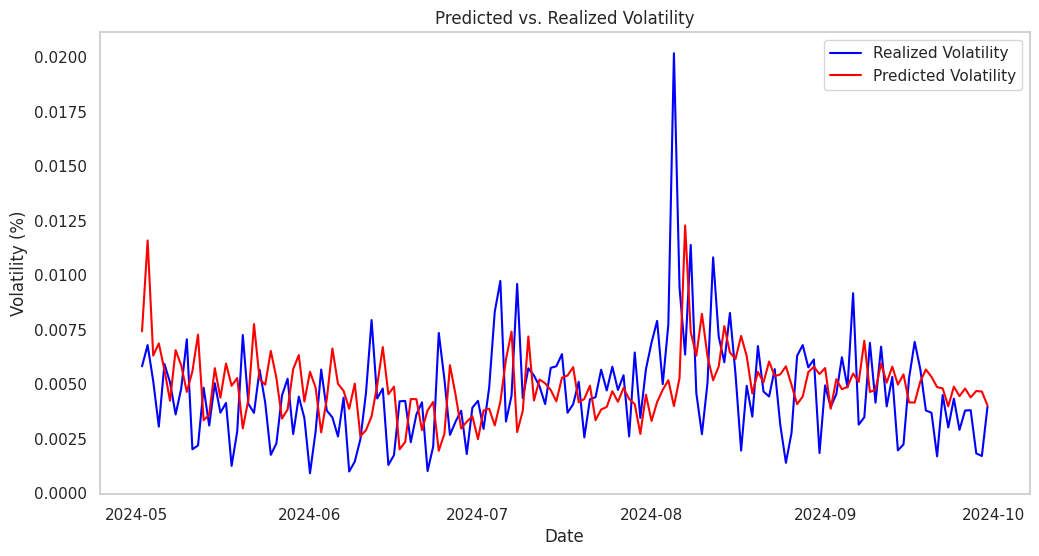

In [407]:
plot_predictions(harq_data, harq_predictions)

In [408]:
print('HARQ:', calculate_metrics(harq_data, harq_predictions))
print('naive:', calculate_metrics(har_data, naive_predictions))

HARQ: {'MSE': 7.8816631939517e-06, 'MAE': 0.0020937682745195705}
naive: {'MSE': 7.85777875642161e-06, 'MAE': 0.0021448638568319265}


# HAR with JUMP


In [409]:
harj_data = generate_HARJ_data(hourly_data, w_len=5, m_len=22)
harj_data = harj_data.dropna()
harj_data.head(15)

,Datetime,rv,daily returns,bpv,jump,rv w,rv m
Datetime,,,,,,,
2024-01-22 00:00:00+00:00,2024-01-22 00:00:00+00:00,0.005675,-0.002085,0.000772,0.004903,0.004197,0.005528
2024-01-23 00:00:00+00:00,2024-01-23 00:00:00+00:00,0.005644,0.000339,0.000581,0.005063,0.004246,0.005586
2024-01-24 00:00:00+00:00,2024-01-24 00:00:00+00:00,0.004772,0.000258,0.000406,0.004366,0.003884,0.005507
2024-01-25 00:00:00+00:00,2024-01-25 00:00:00+00:00,0.003453,-0.000142,0.000271,0.003182,0.004262,0.005214
2024-01-26 00:00:00+00:00,2024-01-26 00:00:00+00:00,0.005714,0.001955,0.000839,0.004874,0.005051,0.005276
2024-01-27 00:00:00+00:00,2024-01-27 00:00:00+00:00,0.002087,0.000261,0.000099,0.001988,0.004334,0.005085
2024-01-28 00:00:00+00:00,2024-01-28 00:00:00+00:00,0.003817,-0.000089,0.000302,0.003515,0.003968,0.005156
2024-01-29 00:00:00+00:00,2024-01-29 00:00:00+00:00,0.004717,0.001218,0.000537,0.004180,0.003958,0.005218
2024-01-30 00:00:00+00:00,2024-01-30 00:00:00+00:00,0.003377,-0.000324,0.000172,0.003204,0.003942,0.005013


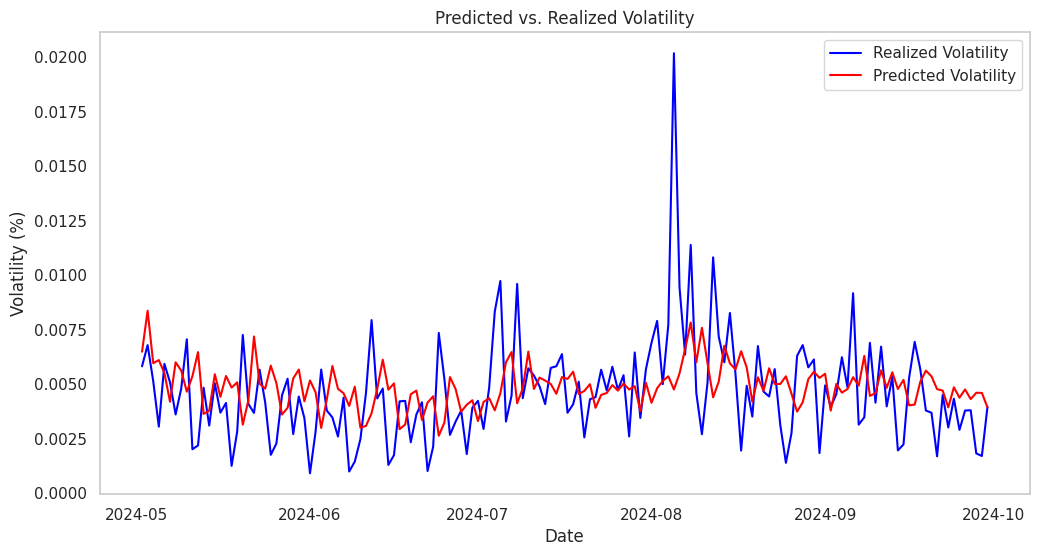

In [410]:
harj_predictions = get_rolling_har_predictions(harj_data, model_name='HAR-J')
plot_predictions(harj_data, harj_predictions)

In [411]:
print('HAR:', calculate_metrics(har_data, har_predictions))
print('HAR-J:', calculate_metrics(harj_data, harj_predictions))
print('naive:', calculate_metrics(harj_data, naive_predictions))

HAR: {'MSE': 6.3269195155717025e-06, 'MAE': 0.0017973804214804138}
HAR-J: {'MSE': 6.396753751669564e-06, 'MAE': 0.0018300405109578511}
naive: {'MSE': 7.85777875642161e-06, 'MAE': 0.0021448638568319265}


# GARCH

In [412]:
def get_rolling_garch_predictions(returns, model_params, window_size=100):
    vol_forecast = []
    mul_returns = returns * 1000
    for i in range(window_size, len(mul_returns)):
        window_data = mul_returns[i-window_size:i]
        model = arch_model(window_data, **model_params)
        garch_fit = model.fit(disp="off", options={'maxiter': 350})
        # Forecast one-step ahead volatility
        vol_forecast.append(garch_fit.forecast(horizon=1).variance.values[-1, :][0])

    # Align the forecast with the returns data
    vol_forecast = pd.Series(vol_forecast, index=returns.index[window_size:])
    # return vol_forecast
    return np.sqrt(vol_forecast * 24) / 1000

In [413]:
model_params = {'vol': 'garch', 'q': 1, 'p': 1, 'o': 1}
garch_predictions = get_rolling_garch_predictions(har_data['daily returns'], model_params)

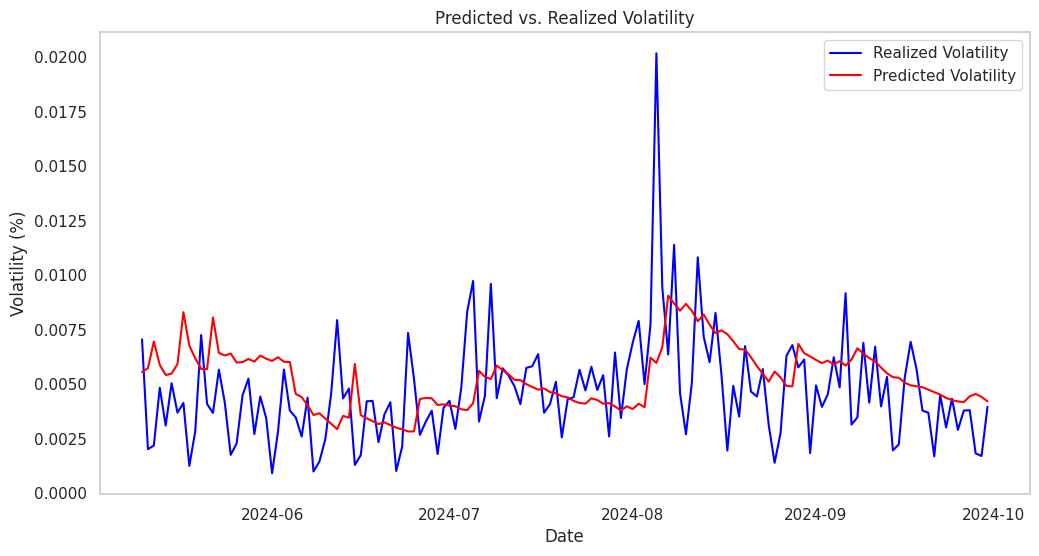

In [414]:
plot_predictions(har_data, garch_predictions.values)

In [415]:
print('HAR:', calculate_metrics(har_data, har_predictions))
print('naive:', calculate_metrics(har_data, naive_predictions))
print('GARCH:', calculate_metrics(har_data, garch_predictions.values))

HAR: {'MSE': 6.3269195155717025e-06, 'MAE': 0.0017973804214804138}
naive: {'MSE': 7.85777875642161e-06, 'MAE': 0.0021448638568319265}
GARCH: {'MSE': 6.94555416920314e-06, 'MAE': 0.0019762663419717963}


In [416]:
print('naive:', calculate_metrics(har_data, naive_predictions))
print('HAR:',   calculate_metrics(har_data, har_predictions))
print('HARQ:',  calculate_metrics(harq_data, harq_predictions))
print('HAR-J:', calculate_metrics(harj_data, harj_predictions))
print('GARCH:', calculate_metrics(har_data, garch_predictions.values))

naive: {'MSE': 7.85777875642161e-06, 'MAE': 0.0021448638568319265}
HAR: {'MSE': 6.3269195155717025e-06, 'MAE': 0.0017973804214804138}
HARQ: {'MSE': 7.8816631939517e-06, 'MAE': 0.0020937682745195705}
HAR-J: {'MSE': 6.396753751669564e-06, 'MAE': 0.0018300405109578511}
GARCH: {'MSE': 6.94555416920314e-06, 'MAE': 0.0019762663419717963}


In [418]:
naive_metrics = calculate_metrics(har_data, naive_predictions)
har_metrics   = calculate_metrics(har_data, har_predictions)
harq_metrics  = calculate_metrics(harq_data, harq_predictions)
harj_metrics  = calculate_metrics(harj_data, harj_predictions)
garch_metrics = calculate_metrics(har_data, garch_predictions.values)

table_data = [
    ['naive', naive_metrics['MSE'] / naive_metrics['MSE'], naive_metrics['MAE'] / naive_metrics['MAE']],
    ['HAR',   naive_metrics['MSE'] / har_metrics  ['MSE'], naive_metrics['MAE'] / har_metrics  ['MAE']],
    ['HARQ',  naive_metrics['MSE'] / harq_metrics ['MSE'], naive_metrics['MAE'] / harq_metrics ['MAE']],
    ['HAR-J', naive_metrics['MSE'] / harj_metrics ['MSE'], naive_metrics['MAE'] / harj_metrics ['MAE']],
    ['GARCH', naive_metrics['MSE'] / garch_metrics['MSE'], naive_metrics['MAE'] / garch_metrics['MAE']]
]


def plot_table(data):
    table = pd.DataFrame(data, columns=["Model", "MSE", "MAE"])
    plt.figure(figsize=(8, 4))
    sns.set(style="whitegrid")
    styled_table = table.style.background_gradient(cmap="Oranges")#, subset=['MSSE', 'MASE'])
    styled_table = styled_table.set_properties(**{'text-align': 'center'})
    display(styled_table)

plot_table(table_data)

,Model,MSE,MAE
0,naive,1.000000,1.000000
1,HAR,1.241960,1.193328
2,HARQ,0.996970,1.024404
3,HAR-J,1.228401,1.172031
4,GARCH,1.131339,1.085311


<Figure size 800x400 with 0 Axes>

In [424]:
hourly_data = get_hourly_data(name='ETH')

har_data = generate_HAR_data(hourly_data)
har_data = har_data.dropna()
har_predictions = get_rolling_har_predictions(har_data, model_name='HAR')

naive_predictions = get_naive_predictions(har_data)

harq_data = generate_HARQ_data(hourly_data, w_len=5, m_len=22)
harq_data = harq_data.dropna()
harq_predictions = get_rolling_har_predictions(harq_data, model_name='HARQ')

harj_data = generate_HARJ_data(hourly_data, w_len=5, m_len=22)
harj_data = harj_data.dropna()
harj_predictions = get_rolling_har_predictions(harj_data, model_name='HAR-J')

model_params = {'vol': 'garch', 'q': 1, 'p': 1}
garch_predictions = get_rolling_garch_predictions(har_data['daily returns'], model_params)

naive_metrics = calculate_metrics(har_data, naive_predictions)
har_metrics   = calculate_metrics(har_data, har_predictions)
harq_metrics  = calculate_metrics(harq_data, harq_predictions)
harj_metrics  = calculate_metrics(harj_data, harj_predictions)
garch_metrics = calculate_metrics(har_data, garch_predictions.values)

table_data = [
    ['naive', naive_metrics['MSE'] / naive_metrics['MSE'], naive_metrics['MAE'] / naive_metrics['MAE']],
    ['HAR',   naive_metrics['MSE'] / har_metrics  ['MSE'], naive_metrics['MAE'] / har_metrics  ['MAE']],
    ['HARQ',  naive_metrics['MSE'] / harq_metrics ['MSE'], naive_metrics['MAE'] / harq_metrics ['MAE']],
    ['HAR-J', naive_metrics['MSE'] / harj_metrics ['MSE'], naive_metrics['MAE'] / harj_metrics ['MAE']],
    ['GARCH', naive_metrics['MSE'] / garch_metrics['MSE'], naive_metrics['MAE'] / garch_metrics['MAE']]
]

plot_table(table_data)

[*********************100%***********************]  1 of 1 completed


,Model,MSE,MAE
0,naive,1.000000,1.000000
1,HAR,1.274711,1.198585
2,HARQ,1.236882,1.103492
3,HAR-J,1.344284,1.216280
4,GARCH,0.806355,0.932854


<Figure size 800x400 with 0 Axes>